In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from sqlalchemy import text
import warnings
warnings.filterwarnings('ignore')

# Imports específicos del proyecto
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
from database.connection import get_db_manager

In [2]:
# Conexión BD
db = get_db_manager()

# Query unificado 5 grandes ligas domésticas - columnas específicas
big5_query = """
SELECT 
    unique_player_id,
    player_name,
    team,
    league,
    season,
    position,
    nationality,
    age,
    fbref_metrics,
    understat_metrics
FROM footballdecoded.players_domestic p
WHERE p.league IN (
    'ENG-Premier League',
    'ESP-La Liga', 
    'ITA-Serie A',
    'GER-Bundesliga',
    'FRA-Ligue 1'
)
ORDER BY p.league, p.season DESC, p.team, p.player_name
"""

# Extracción a DataFrame
df_big5 = pd.read_sql(big5_query, db.engine)
db.close()

df_big5.head()

,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
0,4297cac0772af3c8,Ben White,Arsenal,ENG-Premier League,2425,DF,ENG,26.0,"{'CS': '1', 'FK': '0', 'OG': '0', '/90': '-0.0...","{'understat_xa': '1.4500398263335228', 'unders..."
1,258ed61985702bb2,Bukayo Saka,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,22.0,"{'FK': '1', 'OG': '0', 'Crs': '117', 'Fld': '3...","{'understat_xa': '11.583731275051832', 'unders..."
2,57f809b3be3768e0,David Raya,Arsenal,ENG-Premier League,2425,GK,ESP,28.0,"{'CS': '13', 'FK': '0', 'OG': '0', '/90': '0.0...","{'understat_xa': '0.09363602846860886', 'under..."
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
4,40384e981d1a5c3c,Ethan Nwaneri,Arsenal,ENG-Premier League,2425,"FW,MF",ENG,17.0,"{'FK': '1', 'OG': '0', 'Crs': '54', 'Fld': '5'...","{'understat_xa': '1.1617773352190852', 'unders..."


In [3]:
# Posiciones únicas y conteos
positions = df_big5['position'].value_counts().sort_index()
print(f"Posiciones: {sorted(df_big5['position'].unique())}")

Posiciones: ['DF', 'DF,FW', 'DF,MF', 'FW', 'FW,DF', 'FW,MF', 'GK', 'MF', 'MF,DF', 'MF,FW']


In [4]:
# Filtrar MF como primera posición (MF, MF,FW, MF,DF)
df_midfielders = df_big5[df_big5['position'].str.startswith('MF')].copy()

In [5]:
# Extraer todas las métricas disponibles
fbref_metrics_all = set()
understat_metrics_all = set()

# Recorrer todos los registros para obtener métricas únicas
for _, row in df_midfielders.iterrows():
    if row['fbref_metrics']:
        fbref_metrics_all.update(row['fbref_metrics'].keys())
    if row['understat_metrics']:
        understat_metrics_all.update(row['understat_metrics'].keys())

print("MÉTRICAS FBREF DISPONIBLES:")
print("=" * 50)
fbref_sorted = sorted(list(fbref_metrics_all))
for i, metric in enumerate(fbref_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal FBref: {len(fbref_sorted)}")

print("\n\nMÉTRICAS UNDERSTAT DISPONIBLES:")
print("=" * 50)
understat_sorted = sorted(list(understat_metrics_all))
for i, metric in enumerate(understat_sorted, 1):
    print(f"{i:2d}. {metric}")

print(f"\nTotal Understat: {len(understat_sorted)}")

MÉTRICAS FBREF DISPONIBLES:
 1. /90
 2. 2CrdY
 3. A-xAG
 4. Aerial Duels_Lost
 5. Aerial Duels_Won
 6. Aerial Duels_Won%
 7. Blocks_Blocks
 8. Blocks_Pass
 9. Blocks_Sh
10. CS
11. CS%
12. Carries_1/3
13. Carries_CPA
14. Carries_Carries
15. Carries_Dis
16. Carries_Mis
17. Carries_PrgC
18. Carries_PrgDist
19. Carries_TotDist
20. Challenges_Att
21. Challenges_Lost
22. Challenges_Tkl
23. Challenges_Tkl%
24. Corner Kicks_In
25. Corner Kicks_Out
26. Corner Kicks_Str
27. Crosses_Opp
28. Crosses_Stp
29. Crosses_Stp%
30. Crs
31. CrsPA
32. FK
33. Fld
34. Fls
35. G+A-PK
36. G-xG
37. GA90
38. GCA Types_Def
39. GCA Types_Fld
40. GCA Types_PassDead
41. GCA Types_PassLive
42. GCA Types_Sh
43. GCA Types_TO
44. GCA_GCA
45. GCA_GCA90
46. Goal Kicks_Att
47. Goal Kicks_AvgLen
48. Goal Kicks_Launch%
49. Goals_CK
50. Goals_FK
51. Goals_GA
52. Goals_OG
53. Goals_PKA
54. Launched_Att
55. Launched_Cmp
56. Launched_Cmp%
57. Min%
58. OG
59. Off
60. Outcomes_Blocks
61. Outcomes_Cmp
62. Outcomes_Off
63. PKcon
64. 

In [6]:
df_mf_800min = df_midfielders[
    df_midfielders['fbref_metrics'].apply(
        lambda x: x.get('minutes_played', 0) if x else 0
    ) > 800
].copy()

df_mf_800min.head()

,unique_player_id,player_name,team,league,season,position,nationality,age,fbref_metrics,understat_metrics
3,bb58d04ee12cd7fd,Declan Rice,Arsenal,ENG-Premier League,2425,MF,ENG,25.0,"{'FK': '2', 'OG': '0', 'Crs': '164', 'Fld': '1...","{'understat_xa': '9.060594327747822', 'underst..."
14,15f74098eae8def9,Martin Ødegaard,Arsenal,ENG-Premier League,2425,MF,NOR,25.0,"{'CS': '5', 'FK': '3', 'OG': '0', '/90': '0.09...","{'understat_xa': '5.264152456074953', 'underst..."
15,75214f2690ef4257,Mikel Merino,Arsenal,ENG-Premier League,2425,"MF,FW",ESP,28.0,"{'FK': '0', 'OG': '0', 'Crs': '13', 'Fld': '23...","{'understat_xa': '2.1651013009250164', 'unders..."
23,205844f19cd6b707,Thomas Partey,Arsenal,ENG-Premier League,2425,"MF,DF",GHA,31.0,"{'FK': '0', 'OG': '0', 'Crs': '12', 'Fld': '31...","{'understat_xa': '2.580821704119444', 'underst..."
25,72810ae068cf92ba,Amadou Onana,Aston Villa,ENG-Premier League,2425,MF,BEL,22.0,"{'CS': '9', 'FK': '0', 'OG': '0', '/90': '0.03...","{'understat_xa': '0.6834856616333127', 'unders..."


In [7]:
def extract_metrics(df, col_name):
    """Extrae métricas numéricas de diccionarios - versión robusta"""
    result = pd.DataFrame(index=df.index)
    
    # Obtener todas las keys únicas
    all_keys = set()
    for _, row in df.iterrows():
        if isinstance(row[col_name], dict):
            all_keys.update(row[col_name].keys())
    
    # Extraer cada métrica con conversión robusta
    for key in all_keys:
        values = []
        for _, row in df.iterrows():
            if isinstance(row[col_name], dict) and key in row[col_name]:
                raw_value = row[col_name][key]
                converted_value = _convert_to_float(raw_value)
                values.append(converted_value)
            else:
                values.append(np.nan)
        
        # Solo incluir métricas con al menos 5 valores válidos
        valid_count = pd.Series(values).notna().sum()
        if valid_count >= 5:
            result[key] = values
    
    return result

def _convert_to_float(value):
    """Convierte cualquier valor a float de manera robusta"""
    # Caso 1: Ya es numérico
    if isinstance(value, (int, float)):
        return float(value)
    
    # Caso 2: None o NaN
    if value is None or pd.isna(value):
        return np.nan
    
    # Caso 3: String
    if isinstance(value, str):
        # String vacío
        if value.strip() == '':
            return np.nan
        
        # String "nan" o similares
        if value.lower().strip() in ['nan', 'none', 'null', '-']:
            return np.nan
        
        # Intentar conversión numérica
        try:
            return float(value)
        except (ValueError, TypeError):
            return np.nan
    
    # Caso 4: Cualquier otra cosa
    return np.nan

# Usar la función corregida
fbref_nums = extract_metrics(df_mf_800min, 'fbref_metrics')
understat_nums = extract_metrics(df_mf_800min, 'understat_metrics')

print(f"FBref: {fbref_nums.shape[1]} métricas extraídas")
print(f"Understat: {understat_nums.shape[1]} métricas extraídas")

FBref: 185 métricas extraídas
Understat: 10 métricas extraídas


In [8]:
# Percentiles (1-99, sin llegar a 100)
fbref_pct = fbref_nums.rank(pct=True) * 98 + 1
fbref_pct = fbref_pct.round(0).astype('Int64')
fbref_pct.columns = [f'{col}_pct' for col in fbref_pct.columns]

understat_pct = understat_nums.rank(pct=True) * 98 + 1
understat_pct = understat_pct.round(0).astype('Int64') 
understat_pct.columns = [f'{col}_pct' for col in understat_pct.columns]

print(f"Percentiles: {fbref_pct.shape[1]} + {understat_pct.shape[1]}")

Percentiles: 185 + 10


In [9]:
# Métricas a excluir de per90 (ya normalizadas o ratios)
exclude_per90 = {
    'pass_completion_pct', 'shots_on_target_pct', 'Take-Ons_Succ%', 'Take-Ons_Tkld%', 
    'Aerial Duels_Won%', 'Challenges_Tkl%', 'Save%', 'Launched_Cmp%', 'Crosses_Stp%',
    'shots_per_90', 'GA90', 'GCA_GCA90', 'SCA_SCA90', 'Team Success_+/-90', 'SoT/90',
    'npxG/Sh', 'xG+xAG', 'non_penalty_xG_plus_xAG', 'avg_shot_distance', 'minutes_per_match',
    'Passes_AvgLen', 'Goal Kicks_AvgLen', 'Starts_Mn/Start', 'Subs_Mn/Sub', 'Min%',
    'matches_played', 'matches_started', 'minutes_played', 'wins', 'draws', 'losses',
    'understat_buildup_involvement_pct', 'understat_player_id', 'understat_team_id'
}

# Per90 FBref
fbref_per90 = fbref_nums.loc[:, ~fbref_nums.columns.isin(exclude_per90)]
fbref_per90 = (fbref_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
fbref_per90.columns = [f'{col}_per90' for col in fbref_per90.columns]

# Per90 Understat
understat_per90 = understat_nums.loc[:, ~understat_nums.columns.isin(exclude_per90)]
understat_per90 = (understat_per90.div(fbref_nums['minutes_played'], axis=0) * 90).round(3)
understat_per90.columns = [f'{col}_per90' for col in understat_per90.columns]

print(f"Per90: {fbref_per90.shape[1]} + {understat_per90.shape[1]}")

Per90: 154 + 7


In [10]:
# DataFrame final
df_final = pd.concat([
    df_mf_800min[['unique_player_id', 'player_name', 'team', 'league', 'season', 'position']],  # Sin minutes_played
    fbref_nums,           # Métricas originales FBref (incluye minutes_played)
    understat_nums,       # Métricas originales Understat
    fbref_pct,           # Percentiles FBref
    understat_pct,       # Percentiles Understat
    fbref_per90,         # Per90 FBref
    understat_per90      # Per90 Understat
], axis=1)

In [11]:
def clean_series_values(df):
    for col in df.columns:
        # Detectar Series anidados
        series_mask = df[col].apply(lambda x: isinstance(x, pd.Series))
        
        if series_mask.any():
            print(f"Limpiando Series en: {col}")
            df[col] = df[col].apply(
                lambda x: x.iloc[0] if isinstance(x, pd.Series) and not x.empty else x
            )
    return df

df_final = clean_series_values(df_final)
# Solución drástica: eliminar la columna problemática
df_final = df_final.drop(columns=['shots_on_target_pct'])

Limpiando Series en: shots_on_target_pct
Limpiando Series en: shots_on_target_pct


In [12]:
# Todas las columnas con tipo y ejemplo
ejemplo = df_final.iloc[0]

for col in df_final.columns:
    val = ejemplo[col]
    tipo = type(val).__name__
    print(f"{col:<45} {tipo:<10} {val}")

unique_player_id                              str        bb58d04ee12cd7fd
player_name                                   str        Declan Rice
team                                          str        Arsenal
league                                        str        ENG-Premier League
season                                        str        2425
position                                      str        MF
Aerial Duels_Won%                             float64    59.7
passes_final_third                            float64    137.0
expected_assists                              float64    6.6
Team Success (xG)_xG+/-90                     float64    0.7
Carries_CPA                                   float64    16.0
Carries_Dis                                   float64    32.0
Progression_PrgP                              float64    192.0
GA90                                          float64    nan
Penalty Kicks_PKA                             float64    nan
passes_penalty_area                   

In [13]:
# Buscar jugadores en el DataFrame
search1 = df_midfielders[df_midfielders['player_name'].str.contains('Pedri', case=False, na=False)]
search2 = df_midfielders[df_midfielders['player_name'].str.contains('Bellingham', case=False, na=False)]

for _, player in search1.iterrows():
    print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league']})")
    
for _, player in search2.iterrows():
    print(f"  {player['unique_player_id']} - {player['player_name']} ({player['team']}, {player['league']})")

  8c50fb1a1662d90f - Pedri (Barcelona, ESP-La Liga)
  1b18fe1684f965aa - Jude Bellingham (Real Madrid, ESP-La Liga)


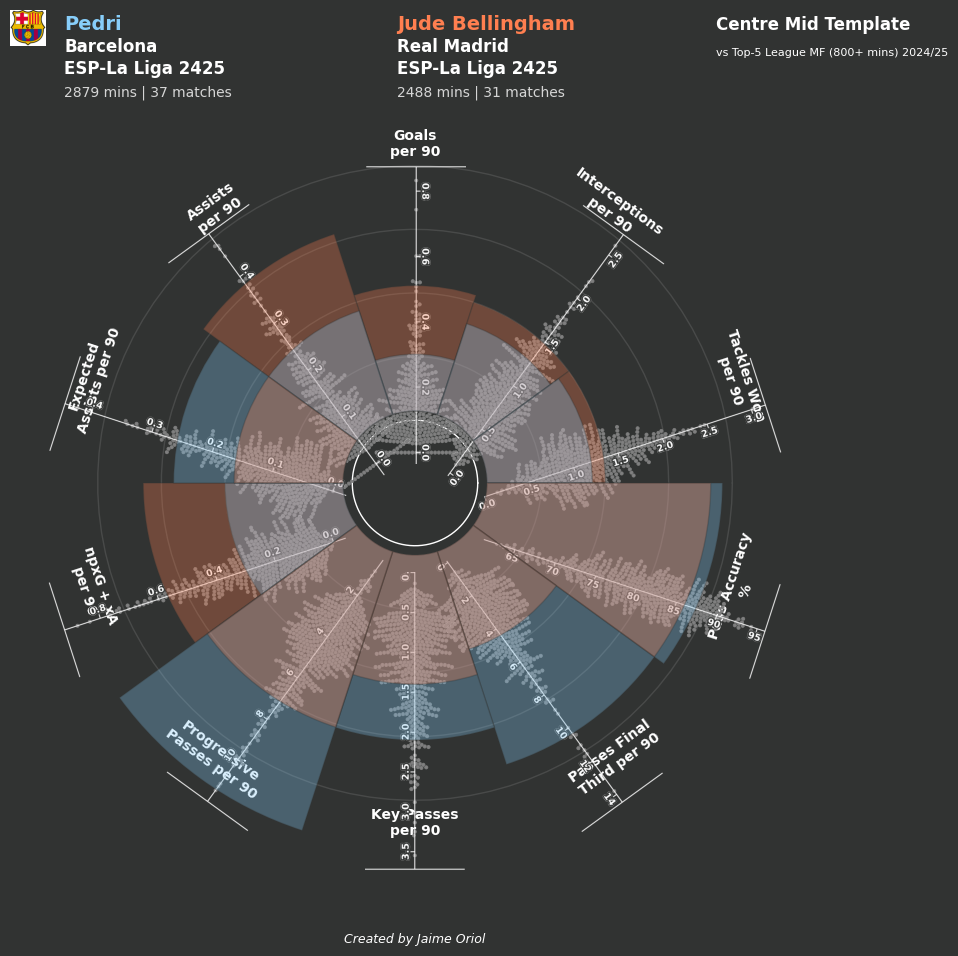

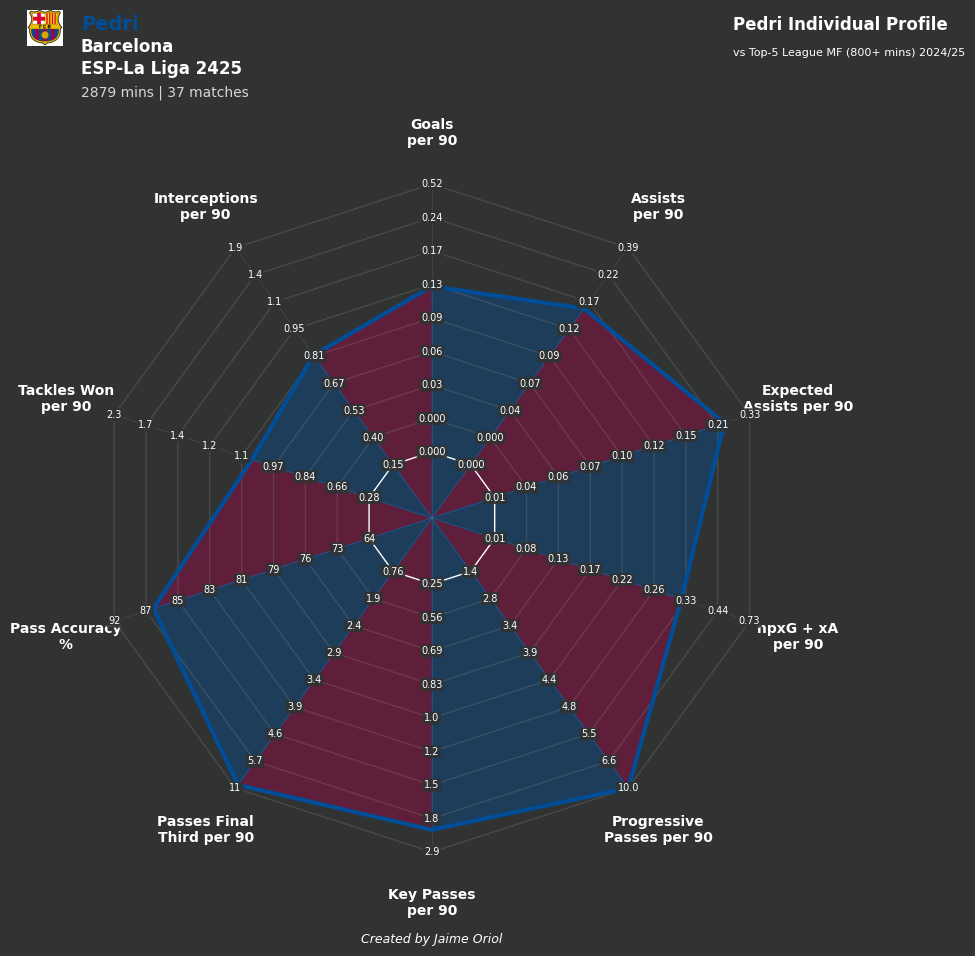

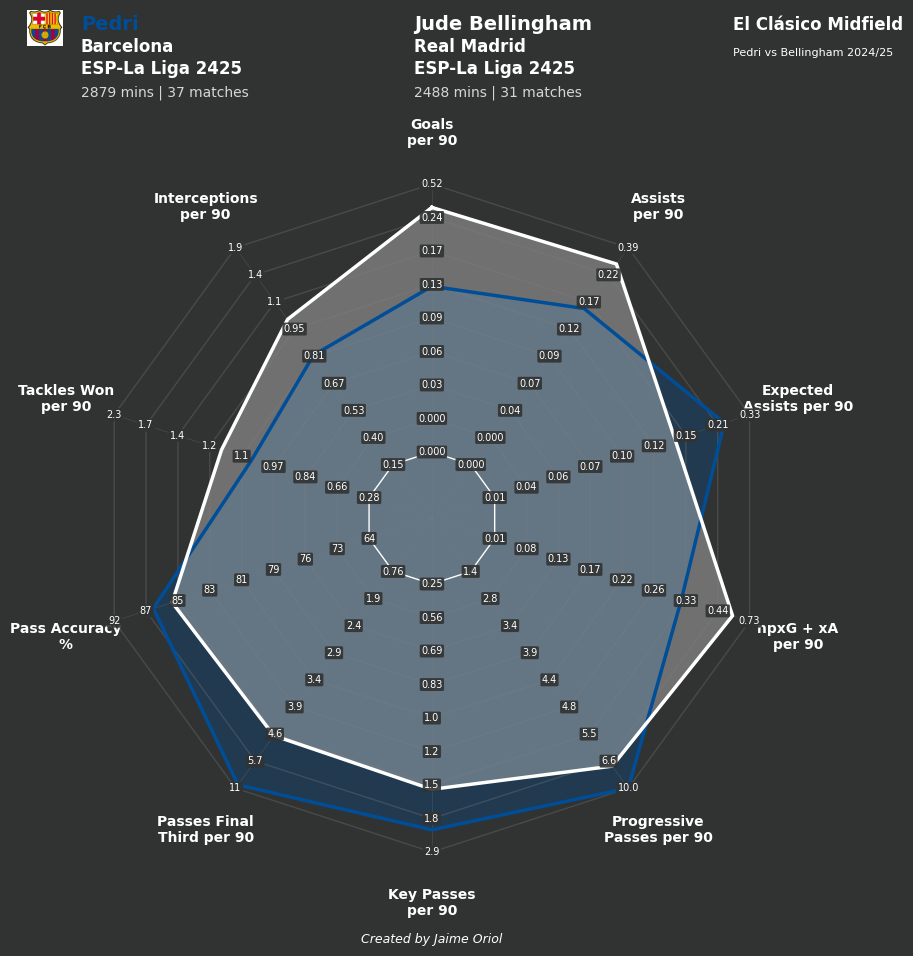

In [14]:
# Import de la función
from viz.swarm_radar import create_player_radar

# Métricas para mediocampistas (10 métricas) - versiones per90
metrics = [
    'goals_per90', 'assists_per90',
    'expected_assists_per90', 'understat_npxg_plus_xa_per90', 'progressive_passes_per90',
    'key_passes_per90', 'passes_final_third_per90', 'pass_completion_pct',
    'tackles_won_per90', 'interceptions_per90'
]

metric_titles = [
    'Goals\nper 90', 'Assists\nper 90', 
    'Expected\nAssists per 90', 'npxG + xA\nper 90', 'Progressive\nPasses per 90',
    'Key Passes\nper 90', 'Passes Final\nThird per 90', 'Pass Accuracy\n%',
    'Tackles Won\nper 90', 'Interceptions\nper 90'
]

# Diccionario de logos
team_logos = {
    'Barcelona': 'logos/barcelona.png',
    # 'Real Madrid': 'viz/logos/real_madrid.png'  # Si tuvieras el logo
}

# 1. SWARM RADAR - Pedri vs Bellingham
create_player_radar(
    df_data=df_final,
    player_1_id="8c50fb1a1662d90f",  # Pedri
    player_2_id="1b18fe1684f965aa",  # Bellingham
    metrics=metrics,
    metric_titles=metric_titles,
    radar_title="Centre Mid Template",
    radar_description="vs Top-5 League MF (800+ mins) 2024/25",
    save_path="images/PedriBellingham-SR.png",
    team_logos=team_logos  # ← AÑADIDO AQUÍ
)

# 2. RADAR TRADICIONAL - Solo Pedri con logo
create_player_radar(
    df_data=df_final,
    player_1_id="8c50fb1a1662d90f",  # Pedri
    metrics=metrics,
    metric_titles=metric_titles,
    radar_title="Pedri Individual Profile",
    radar_description="vs Top-5 League MF (800+ mins) 2024/25",
    save_path="images/pedri_radar.png",
    use_swarm=False,
    team_colors=['#004D98', '#A50044'],  # Colores Barcelona
    team_logos=team_logos  # Logo del Barça
)

# 3. RADAR TRADICIONAL - Pedri vs Bellingham con logo Barça
create_player_radar(
    df_data=df_final,
    player_1_id="8c50fb1a1662d90f",  # Pedri
    player_2_id="1b18fe1684f965aa",  # Bellingham
    metrics=metrics,
    metric_titles=metric_titles,
    radar_title="El Clásico Midfield",
    radar_description="Pedri vs Bellingham 2024/25",
    save_path="images/PedriBellingham-R.png",
    use_swarm=False,
    team_colors=['#004D98', '#FFFFFF'],  # Barça vs Madrid
    team_logos=team_logos  # Solo se mostrará logo del Barça
)

In [15]:
# Ver datos de los dos jugadores
player_ids = ["8c50fb1a1662d90f", "1b18fe1684f965aa"]

# Métricas que estamos usando
metrics = [
    'goals', 'assists',
    'expected_assists', 'understat_npxg_plus_xa', 'progressive_passes',
    'key_passes', 'passes_final_third', 'pass_completion_pct',
    'tackles_won', 'interceptions'
]

# Columnas básicas + métricas + percentiles
cols_to_show = ['player_name', 'team', 'minutes_played', 'matches_played'] + metrics + [m + '_pct' for m in metrics]

# Filtrar y mostrar
players_data = df_final[df_final['unique_player_id'].isin(player_ids)][cols_to_show]

# Mostrar transpuesto para mejor visualización
print("DATOS DE LOS JUGADORES:")
print("="*50)
for idx, row in players_data.iterrows():
    print(f"\n{row['player_name']} - {row['team']}")
    print(f"Minutos: {row['minutes_played']}, Partidos: {row['matches_played']}")
    print("-"*30)
    for metric in metrics:
        val = row[metric]
        pct = row[metric + '_pct']
        print(f"{metric:<30} {val:>10.2f} (P{pct})")

DATOS DE LOS JUGADORES:

Pedri - Barcelona
Minutos: 2879.0, Partidos: 37.0
------------------------------
goals                                4.00 (P78)
assists                              5.00 (P87)
expected_assists                     7.40 (P97)
understat_npxg_plus_xa              10.32 (P89)
progressive_passes                 360.00 (P99)
key_passes                          70.00 (P98)
passes_final_third                 331.00 (P99)
pass_completion_pct                 87.40 (P82)
tackles_won                         34.00 (P83)
interceptions                       26.00 (P78)

Jude Bellingham - Real Madrid
Minutos: 2488.0, Partidos: 31.0
------------------------------
goals                                9.00 (P95)
assists                              8.00 (P97)
expected_assists                     3.90 (P83)
understat_npxg_plus_xa              15.90 (P97)
progressive_passes                 199.00 (P93)
key_passes                          42.00 (P86)
passes_final_third              